In [23]:
from math import sin 
from math import pi
from numpy import arange
from numpy import asarray
from numpy import vstack
from numpy import argmax
from numpy.random import normal 
from numpy.random import random 
from scipy.stats import norm
from matplotlib import pyplot
from warnings import catch_warnings
from warnings import simplefilter 
from sklearn.gaussian_process import GaussianProcessRegressor


In [17]:
def objective(x, noise=0.1): # implements a multimodal problem and adds Gaussian noise to make the function challenging to optimise 
    noise = normal(loc=0, scale=noise)
    return (x**2 * sin(5*pi*x)**6)+noise    

Reviewing the test function that will be optimised

Optima: x=0.900, y=0.810


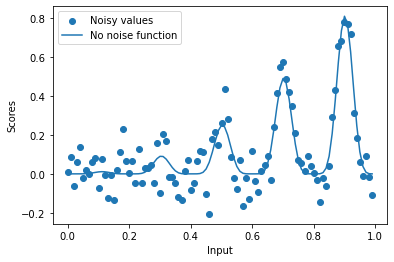

In [38]:
X = arange(0,1,0.01) # defining a grid-based sample of inputs in domain [0,1]
y = [objective(x,0) for x in X] # evaluate the samples using the objective function without any noise to see the real function
ynoise = [objective(x) for x in X] # evaluate with noise to see what the function will look like during optimising 
ix = argmax(y) # finds the best score (without noise) by finding the maxima by maximising the output of the objective function 
print('Optima: x=%.3f, y=%.3f' % (X[ix], y[ix]) ) # would not know these in practise but good to know the real best input and output to see how this optimisation works
pyplot.scatter(X, ynoise) # scatter of the noisy evaluation with input on the x-axis and score on y-axis
pyplot.plot(X,y) # plots the function/scores without any noise 
pyplot.xlabel("Input")
pyplot.ylabel("Scores")
pyplot.legend(["Noisy values", "No noise function"])
pyplot.show()

Training a surrogate function - need to treat the problem as a regression predictive modelling problem with the data being the input and the score representing the output to the model - best done with Gaussian process

In [39]:
def surrogate(model, X): # surrogate/approximation for the objective function, takes the fit model and samples and returns the mean and std estimated costs
    with catch_warnings(): # gets rid of warnings occurring 
        simplefilter("ignore")
        return model.predict(X, return_std=True) # call this function to estimate the cost of samples, eg when we want to optimise the acquisition function 

In [48]:
def plot(X,y,model): # plot sample vs surrogate function 
    pyplot.scatter(X,y) # scatter of inputs and real objective function 
    Xsamples = asarray(arange(0,1,0.001)) # line plot of surrogate function
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples,_ = surrogate(model, Xsamples)
    pyplot.plot(Xsamples, ysamples)
    pyplot.xlabel("Input")
    pyplot.ylabel("Scores")
    pyplot.legend(["Sample", "Surrogate function"])
    pyplot.show()

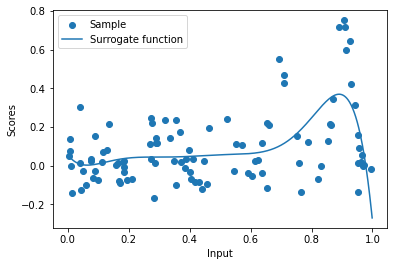

In [49]:
# want to see what the surrogate function looks like across the domain after it is trained on a random sample
X = random(100)
y = asarray([objective(x) for x in X])
X = X.reshape(len(X), 1) # reshape into rows and cols
y = y.reshape(len(y), 1)
model = GaussianProcessRegressor() # define the model
model.fit(X,y) # fit the GP model on a random sample of 100 data points and their real objective function values with noise 
plot(X, y, model) # plot the scatter of the inputs and real objective function and plot a line plot of the surrogate function 

Sampling the surrogate function

In [50]:
def opt_acquisition(X,y,model): # optimise the acquisition function 
    Xsamples=random(100)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    scores = acquisition(X, Xsamples, model) # calculate the acquisition function for each sample 
    ix = argmax(scores) # get the index of the best scores 
    return Xsamples[ix,0]

def acquisition(X, Xsamples, model): # acquisition function using probability of improvement method
    yhat,_ = surrogate(model,X) # calculate the best surrogate score found so far 
    best = max(yhat)
    mu, std = surrogate(model, Xsamples) # calculate mean and std via surrogate function 
    # mu = mu[:,0]
    probs = norm.cdf((mu-best)/(std+1e-9)) # calculate the probability of improvement
    return probs

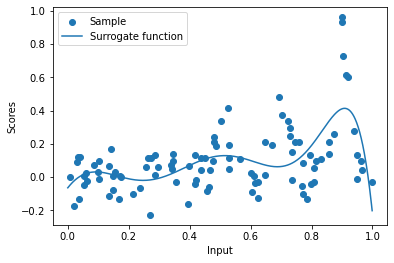

In [58]:
X = random(100)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model) # plot the scatter of the inputs and real objective function and plot a line plot of the surrogate function 


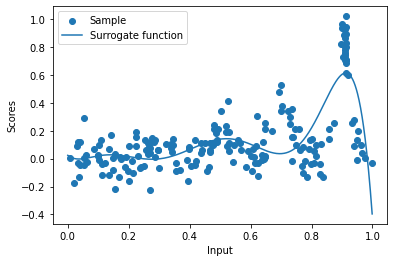

Best Result: x=0.913, y=1.020


In [59]:
for i in range(100): # performing optimisation 
    x = opt_acquisition(X,y,model) # select the next point to sample 
    actual=objective(x) # sample it
    est, _ = surrogate(model, [[x]]) # summarise finding 
    # print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
    X = vstack((X, [[x]])) # add to dataset 
    y = vstack((y, [[actual]]))
    model.fit(X,y) # update model with new data 

plot(X,y,model) # plot the scatter of the inputs and real objective function and plot a line plot of the surrogate function 
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix])) # see that the best result is very close to the optima from above 

Hyperparameter tuning with Bayesian Optimisation 